# MHKiT Power Module  
The following example uses the [MHKiT power module](https://mhkit-software.github.io/MHKiT/mhkit-python/api.power.html) to compute power, instantaneous frequency, and harmonics from time-series of voltage and current. 

Start by importing the necessary python packages and MHKiT module.

In [1]:
import numpy as np
import pandas as pd
from mhkit import power, utils
from mhkit.dolfyn.tools.fft import fft_frequency, cpsd_quasisync_1D, psd_1D
import matplotlib.pyplot as plt

## Load Power Data
We will begin by reading in time-series data of measured three phase (a, b, and c) voltage and current. 

Note: IEC TS 62600-30 requires power quality assessments on a minimum of 10 minute time-series data, but for this example a shorter time-series is used. 


In [2]:
# Read in time-series data of voltage (V) and current (I)
df = pd.read_csv(
    "power-quality-meter.csv", 
    skip_blank_lines=True,
    index_col=0  # Use first column as index
)

# Create a datetime index by combining Date and Time columns
# Handle the time format with milliseconds (e.g., "3:21:43 PM.135")
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                               format='%Y-%m-%d %I:%M:%S %p.%f', errors='coerce')

# Set DateTime as index and drop original Date/Time columns
df = df.set_index('DateTime').drop(['Date', 'Time'], axis=1)

# Data quality checks and cleaning
print("DataFrame Info:")
print(f"Shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Time span: {df.index.max() - df.index.min()}")
print(f"Sampling rate: ~{1/df.index.to_series().diff().dt.total_seconds().mean():.1f} Hz")

# Check for missing values
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Remove any rows with missing values
df_clean = df.dropna()
print(f"\nAfter cleaning: {df_clean.shape[0]} rows, {df_clean.shape[1]} columns")

# Display basic statistics
print(f"\nBasic Statistics:")
print(df_clean.describe())

# Display the cleaned data
df_clean.head()

DataFrame Info:
Shape: (2343, 17)
Date range: 2019-08-31 15:21:43.135000 to 2019-09-01 10:52:43.135000
Time span: 0 days 19:31:00
Sampling rate: ~0.0 Hz

Missing values per column:
Vrms ph-n AN Avg            0
Vrms ph-n BN Avg            0
Vrms ph-n CN Avg            0
Vrms ph-n NG Avg            0
Current A Avg               0
Current B Avg               0
Current C Avg               0
Current Phi AN Avg          0
Current Phi BN Avg          0
Current Phi CN Avg          0
Active Power Total Avg      0
Apparent Power Total Avg    0
Reactive Power Total Avg    0
Cos Phi AN Avg              0
Cos Phi BN Avg              0
Cos Phi CN Avg              0
Cos Phi Total Avg           0
dtype: int64

After cleaning: 2343 rows, 17 columns

Basic Statistics:
       Vrms ph-n AN Avg  Vrms ph-n BN Avg  Vrms ph-n CN Avg  Vrms ph-n NG Avg  \
count       2343.000000       2343.000000       2343.000000       2343.000000   
mean         243.279582        242.855408        243.190141          0.64168

,Vrms ph-n AN Avg,Vrms ph-n BN Avg,Vrms ph-n CN Avg,Vrms ph-n NG Avg,Current A Avg,Current B Avg,Current C Avg,Current Phi AN Avg,Current Phi BN Avg,Current Phi CN Avg,Active Power Total Avg,Apparent Power Total Avg,Reactive Power Total Avg,Cos Phi AN Avg,Cos Phi BN Avg,Cos Phi CN Avg,Cos Phi Total Avg
DateTime,,,,,,,,,,,,,,,,,
2019-08-31 15:21:43.135,242.58,241.98,242.12,0.46,596.0,544.7,496.3,-7.74,-135.90,-248.54,389550,397650,73050,0.99,0.96,0.99,0.98
2019-08-31 15:22:13.135,242.98,242.34,242.72,0.48,612.5,541.1,494.8,-18.12,-129.90,-240.30,397800,401550,26400,1.00,0.98,1.00,1.00
2019-08-31 15:22:43.135,243.04,242.18,242.78,0.54,628.3,558.3,508.8,-291.90,-128.06,-238.58,408300,412950,13500,1.00,0.99,1.00,1.00
2019-08-31 15:23:13.135,242.92,242.06,242.70,0.56,640.2,562.5,510.5,-359.42,-128.70,-238.82,412050,417300,16350,1.00,0.99,1.00,1.00
2019-08-31 15:23:43.135,242.52,241.62,242.20,0.54,652.7,587.6,533.5,-167.08,-130.62,-242.02,424650,430650,35100,1.00,0.98,1.00,1.00


In [3]:
# Create organized data structure for better analysis
# Define column groups for easier access
voltage_columns = ["Vrms ph-n AN Avg", "Vrms ph-n BN Avg", "Vrms ph-n CN Avg"]
current_columns = ["Current A Avg", "Current B Avg", "Current C Avg"]
phase_columns = ["Current Phi AN Avg", "Current Phi BN Avg", "Current Phi CN Avg"]
cos_phi_columns = ["Cos Phi AN Avg", "Cos Phi BN Avg", "Cos Phi CN Avg"]
power_columns = ["Active Power Total Avg", "Apparent Power Total Avg", "Reactive Power Total Avg"]

# Create a comprehensive data dictionary for easy reference
data_info = {
    'voltage_phases': voltage_columns,
    'current_phases': current_columns,
    'phase_angles': phase_columns,
    'power_factors': cos_phi_columns,
    'power_quantities': power_columns,
    'neutral_voltage': ["Vrms ph-n NG Avg"],
    'total_power_factor': ["Cos Phi Total Avg"]
}

print("DataFrame Structure:")
print("=" * 50)
for category, columns in data_info.items():
    print(f"{category.replace('_', ' ').title()}: {columns}")

# Create a summary DataFrame for quick analysis
summary_stats = pd.DataFrame({
    'Mean': df_clean[voltage_columns + current_columns].mean(),
    'Std': df_clean[voltage_columns + current_columns].std(),
    'Min': df_clean[voltage_columns + current_columns].min(),
    'Max': df_clean[voltage_columns + current_columns].max()
})

print(f"\nSummary Statistics for Voltage and Current:")
print(summary_stats.round(2))


DataFrame Structure:
Voltage Phases: ['Vrms ph-n AN Avg', 'Vrms ph-n BN Avg', 'Vrms ph-n CN Avg']
Current Phases: ['Current A Avg', 'Current B Avg', 'Current C Avg']
Phase Angles: ['Current Phi AN Avg', 'Current Phi BN Avg', 'Current Phi CN Avg']
Power Factors: ['Cos Phi AN Avg', 'Cos Phi BN Avg', 'Cos Phi CN Avg']
Power Quantities: ['Active Power Total Avg', 'Apparent Power Total Avg', 'Reactive Power Total Avg']
Neutral Voltage: ['Vrms ph-n NG Avg']
Total Power Factor: ['Cos Phi Total Avg']

Summary Statistics for Voltage and Current:
                    Mean     Std   Min      Max
Vrms ph-n AN Avg  243.28   21.22  0.20   253.66
Vrms ph-n BN Avg  242.86   21.22  0.02   254.78
Vrms ph-n CN Avg  243.19   21.24  0.06   253.16
Current A Avg     738.98  176.19  0.10  6276.70
Current B Avg     680.94  239.49  0.10  6276.70
Current C Avg     623.05  130.35  0.10   835.30


## Power Characteristics 
The `power.characteristics` submodule is used to compute quantities of interest from voltage and current time-series. In this example, we will calculate active AC power and instantneous frequency.

### Active AC Power
To compute the active AC power, the user must provide a `power_factor` for the efficency of the device. 


Voltage and Current DataFrames created:
Voltage shape: (2343, 3)
Current shape: (2343, 3)

Voltage columns: ['Phase_A_Voltage', 'Phase_B_Voltage', 'Phase_C_Voltage']
Current columns: ['Phase_A_Current', 'Phase_B_Current', 'Phase_C_Current']
Mean power factor used: 0.983


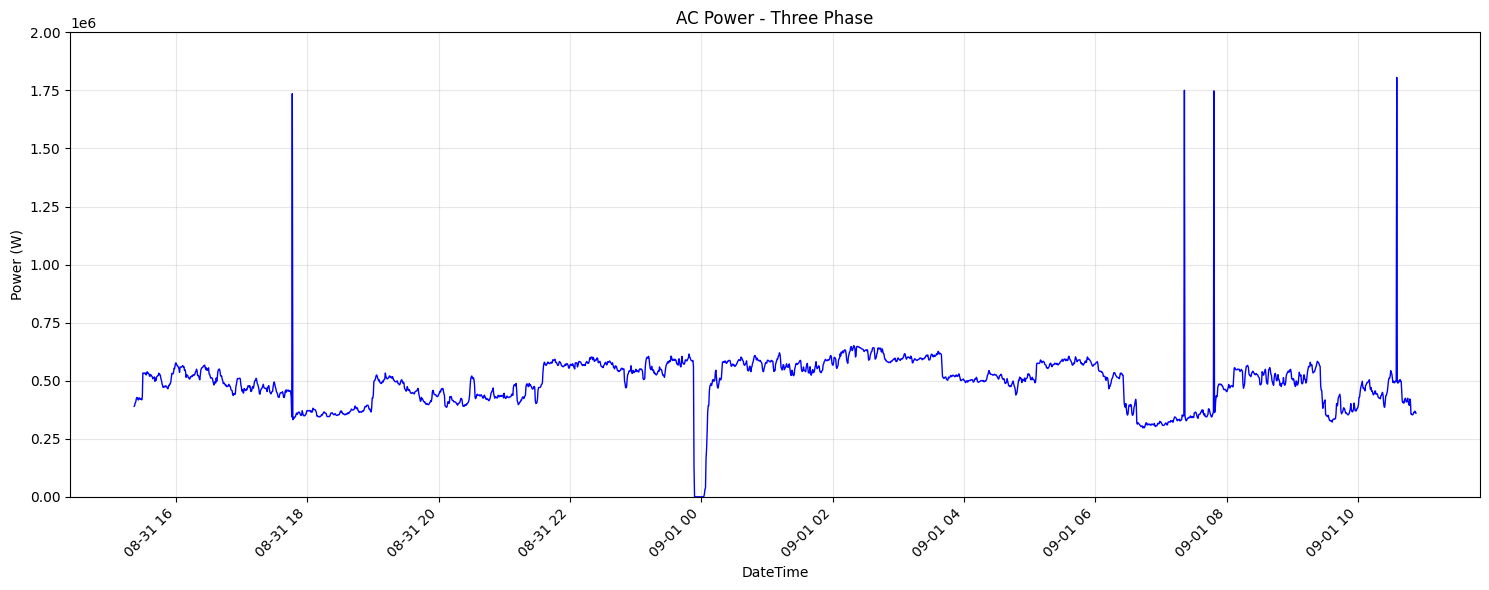


AC Power Statistics:
Mean Power: 491889 W
Max Power: 1805865 W
Min Power: 0 W
Std Power: 109856 W


In [4]:
# Extract voltage and current data using organized column structure
voltage = df_clean[voltage_columns].copy()
current = df_clean[current_columns].copy()

# Rename columns for better readability
voltage.columns = ['Phase_A_Voltage', 'Phase_B_Voltage', 'Phase_C_Voltage']
current.columns = ['Phase_A_Current', 'Phase_B_Current', 'Phase_C_Current']

print("Voltage and Current DataFrames created:")
print(f"Voltage shape: {voltage.shape}")
print(f"Current shape: {current.shape}")
print(f"\nVoltage columns: {list(voltage.columns)}")
print(f"Current columns: {list(current.columns)}")

# Set the power factor for the system
# Option 1: Use a fixed power factor
# power_factor = 0.96

# Option 2: Calculate power factor as the mean of (Active Power Total Avg / Apparent Power Total Avg)
power_factor = (df_clean['Active Power Total Avg'] / df_clean['Apparent Power Total Avg']).mean()
print(f"Mean power factor used: {power_factor:.3f}")

# Compute the instantaneous AC power in watts
ac_power = power.characteristics.ac_power_three_phase(voltage, current, power_factor)

# Display the result with enhanced visualization
fig, ax = plt.subplots(figsize=(15, 6))
ac_power.Power.plot(ax=ax, title="AC Power - Three Phase", color='blue', linewidth=1)
ax.set_xlabel("DateTime")
ax.set_ylabel("Power (W)")
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 2000000)  # Adjusted y-axis limit based on data range
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display power statistics
print(f"\nAC Power Statistics:")
print(f"Mean Power: {ac_power.Power.mean():.0f} W")
print(f"Max Power: {ac_power.Power.max():.0f} W")
print(f"Min Power: {ac_power.Power.min():.0f} W")
print(f"Std Power: {ac_power.Power.std():.0f} W")

In [5]:
# Comprehensive Data Quality Assessment
print("=" * 60)
print("DATA QUALITY ASSESSMENT")
print("=" * 60)

# 1. Data completeness
print("1. Data Completeness:")
print(f"   Total records: {len(df_clean)}")
print(f"   Missing values: {df_clean.isnull().sum().sum()}")
print(f"   Data completeness: {((len(df_clean) - df_clean.isnull().sum().sum()) / (len(df_clean) * len(df_clean.columns)) * 100):.1f}%")

# 2. Time series continuity
time_diffs = df_clean.index.to_series().diff().dt.total_seconds()
print(f"\n2. Time Series Analysis:")
print(f"   Time span: {df_clean.index.max() - df_clean.index.min()}")
print(f"   Average sampling interval: {time_diffs.mean():.1f} seconds")
print(f"   Sampling frequency: {1/time_diffs.mean():.1f} Hz")
print(f"   Time gaps detected: {(time_diffs > time_diffs.median() * 2).sum()}")

# 3. Electrical parameter validation
print(f"\n3. Electrical Parameter Validation:")
print(f"   Voltage range: {df_clean[voltage_columns].min().min():.1f} - {df_clean[voltage_columns].max().max():.1f} V")
print(f"   Current range: {df_clean[current_columns].min().min():.1f} - {df_clean[current_columns].max().max():.1f} A")
print(f"   Power range: {df_clean['Active Power Total Avg'].min():.0f} - {df_clean['Active Power Total Avg'].max():.0f} W")

# 4. Phase balance analysis
voltage_balance = df_clean[voltage_columns].std(axis=1).mean()
current_balance = df_clean[current_columns].std(axis=1).mean()
print(f"\n4. Phase Balance Analysis:")
print(f"   Average voltage unbalance: {voltage_balance:.2f} V")
print(f"   Average current unbalance: {current_balance:.2f} A")

# 5. Power factor analysis
pf_analysis = df_clean[cos_phi_columns].describe()
print(f"\n5. Power Factor Analysis:")
print(f"   Phase A PF: {pf_analysis['Cos Phi AN Avg']['mean']:.3f} ± {pf_analysis['Cos Phi AN Avg']['std']:.3f}")
print(f"   Phase B PF: {pf_analysis['Cos Phi BN Avg']['mean']:.3f} ± {pf_analysis['Cos Phi BN Avg']['std']:.3f}")
print(f"   Phase C PF: {pf_analysis['Cos Phi CN Avg']['mean']:.3f} ± {pf_analysis['Cos Phi CN Avg']['std']:.3f}")

print("\n" + "=" * 60)


DATA QUALITY ASSESSMENT
1. Data Completeness:
   Total records: 2343
   Missing values: 0
   Data completeness: 5.9%

2. Time Series Analysis:
   Time span: 0 days 19:31:00
   Average sampling interval: 30.0 seconds
   Sampling frequency: 0.0 Hz
   Time gaps detected: 0

3. Electrical Parameter Validation:
   Voltage range: 0.0 - 254.8 V
   Current range: 0.1 - 6276.7 A
   Power range: 0 - 4915050 W

4. Phase Balance Analysis:
   Average voltage unbalance: 0.36 V
   Average current unbalance: 62.75 A

5. Power Factor Analysis:
   Phase A PF: 1.130 ± 6.749
   Phase B PF: 1.393 ± 11.685
   Phase C PF: 0.989 ± 0.086



### Instantaneous Frequency

Calculate the instantaneous frequency of the voltage time-series using the 3 phase voltage measurements. The time-varying instantaneous frequency is a required metric for power quality assessments. 

,Phase_A_Voltage,Phase_B_Voltage,Phase_C_Voltage
DateTime,,,
2019-08-31 15:21:43.135,242.58,241.98,242.12
2019-08-31 15:22:13.135,242.98,242.34,242.72
2019-08-31 15:22:43.135,243.04,242.18,242.78
2019-08-31 15:23:13.135,242.92,242.06,242.70
2019-08-31 15:23:43.135,242.52,241.62,242.20


,Phase_A_Voltage,Phase_B_Voltage,Phase_C_Voltage
DateTime,,,
2019-08-31 15:21:43.135,0.000029,0.000031,2.695212e-05
2019-08-31 15:22:13.135,0.000006,0.000004,7.738717e-06
2019-08-31 15:22:43.135,0.000017,0.000015,1.759530e-05
2019-08-31 15:23:13.135,-0.000002,-0.000002,-2.593249e-07
2019-08-31 15:23:43.135,0.000004,0.000004,1.743875e-06


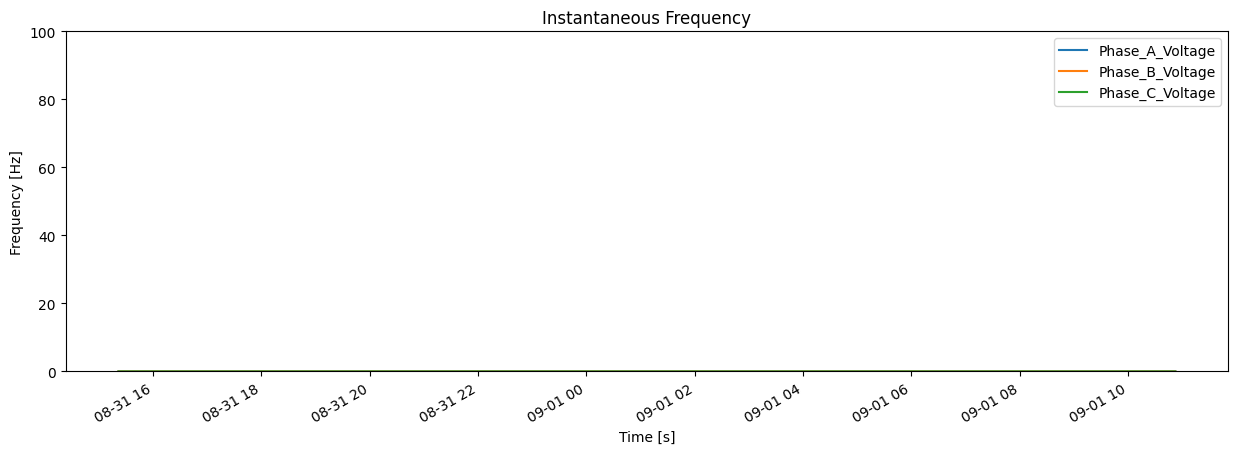

In [6]:
# Compute the instantaneous frequency
inst_freq = power.characteristics.instantaneous_frequency(voltage)
display(voltage.head())

# Display the result
inst_freq.plot(figsize=(15, 5), ylim=(0, 100), title="Instantaneous Frequency").set(
    xlabel="Time [s]", ylabel="Frequency [Hz]"
)
inst_freq.head()

## Power Quality
The `power.quality` module can be used to compute current or voltage harmonics and current distortions following IEC TS 62600-30 and IEC TS 61000-4-7. Harmonics and harmonic distortion are required as part of a power quality assessment and characterize the stability of the produced power. 

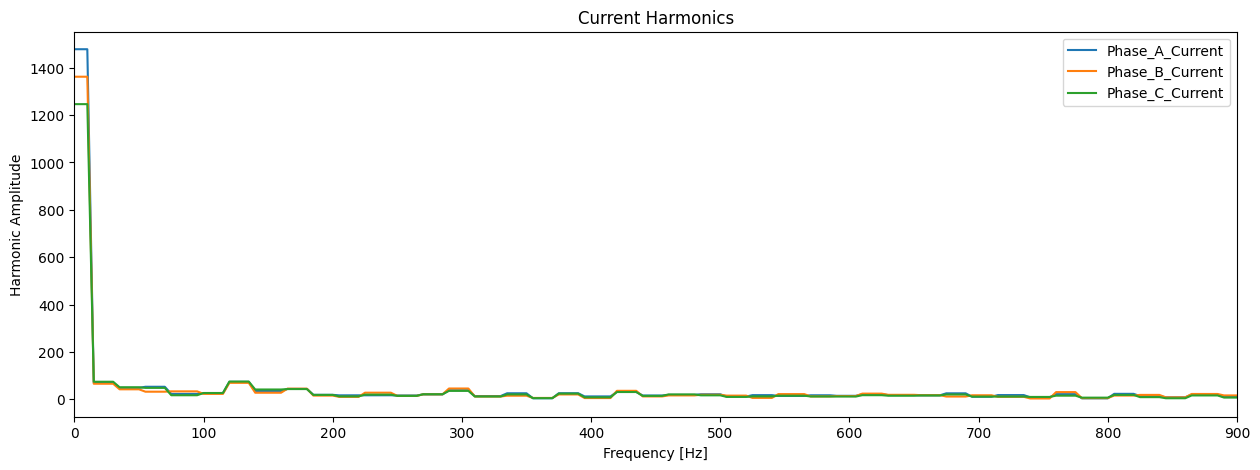

In [7]:
# Set the nominal sampling frequency
sample_freq = 50000  # [Hz]

# Set the frequency of the grid the device would be conected to
grid_freq = 60  # [Hz]

# Set the rated current of the device
rated_current = 600  # [Amps]

# Calculate the harmonics
harmonics = power.quality.harmonics(current, sample_freq, grid_freq)

# Plot the results
harmonics.plot(figsize=(15, 5), xlim=(0, 900), title="Current Harmonics").set(
    ylabel="Harmonic Amplitude", xlabel="Frequency [Hz]"
);

### Harmonic Subgroups
The harmonic subgroups calculations are based on IEC TS 62600-30. We can calculate them using our grid frequency and harmonics.

In [8]:
# Calculate Harmonic Subgroups
h_s = power.quality.harmonic_subgroups(harmonics, grid_freq)

# Add harmonic order as a column based on index/frequency and grid_freq
h_s = h_s.copy()
h_s['Harmonic Order'] = h_s.index / grid_freq

# Display the results with harmonic order
h_s.head(50)

,Phase_A_Current,Phase_B_Current,Phase_C_Current,Harmonic Order
frequency,,,,
0,2090.169277,1925.988207,1762.267619,0.0
60,91.643749,55.601842,83.554158,1.0
120,107.519409,100.818469,109.161909,2.0
180,64.784956,65.492206,63.857712,3.0
240,29.565042,48.368040,34.147149,4.0
300,66.042877,78.942262,61.664164,5.0
360,7.657603,9.993851,8.390557,6.0
420,45.575209,50.918284,44.234427,7.0
480,33.776484,30.106694,33.651342,8.0


In [9]:
# Global FFT Parameters for all analysis
# These parameters will be used throughout the FFT analysis sections
nfft = 1024  # Number of FFT points
fs = 50000   # Sampling frequency [Hz] - consistent with harmonics analysis

print(f"FFT Parameters set:")
print(f"  FFT points (nfft): {nfft}")
print(f"  Sampling frequency (fs): {fs} Hz")
print(f"  Frequency resolution: {fs/nfft:.1f} Hz")


FFT Parameters set:
  FFT points (nfft): 1024
  Sampling frequency (fs): 50000 Hz
  Frequency resolution: 48.8 Hz


### Total Harmonic Current Distortion

Compute the THCD from harmonic subgroups and rated current for the device

## MHKiT Dolfyn FFT Analysis

The `mhkit.dolfyn.tools.fft` module provides advanced spectral analysis functions for power quality assessment. We'll demonstrate three key functions:

1. **`fft_frequency()`** - Computes frequency vector for FFT analysis
2. **`cpsd_quasisync_1D()`** - Cross power spectral density for two signals
3. **`psd_1D()`** - Power spectral density for single signal analysis

These functions are particularly useful for analyzing the spectral characteristics of voltage and current signals in power systems.


### 1. FFT Frequency Vector

First, let's compute the frequency vector for our FFT analysis using the sample frequency from our power data.


In [10]:
# Prepare data for PSD analysis - take a subset for demonstration
# Convert to numpy arrays and remove NaN values
# Use the renamed column names from our organized DataFrame structure
voltage_a = voltage["Phase_A_Voltage"].dropna().values
voltage_b = voltage["Phase_B_Voltage"].dropna().values
voltage_c = voltage["Phase_C_Voltage"].dropna().values
current_a = current["Phase_A_Current"].dropna().values
current_b = current["Phase_B_Current"].dropna().values
current_c = current["Phase_C_Current"].dropna().values

print(f"Data lengths - Voltage A: {len(voltage_a)}, Current A: {len(current_a)}")

# Set FFT parameters for PSD analysis
nfft = 1024  # Number of FFT points
fs = 50000   # Sampling frequency [Hz] - using the same value from harmonics analysis

# Compute PSD for voltage signals
psd_voltage_a = psd_1D(voltage_a, nfft, fs, window='hann')
psd_voltage_b = psd_1D(voltage_b, nfft, fs, window='hann')
psd_voltage_c = psd_1D(voltage_c, nfft, fs, window='hann')

# Compute PSD for current signals
psd_current_a = psd_1D(current_a, nfft, fs, window='hann')
psd_current_b = psd_1D(current_b, nfft, fs, window='hann')
psd_current_c = psd_1D(current_c, nfft, fs, window='hann')

print(f"PSD array lengths: {len(psd_voltage_a)}")
print(f"PSD voltage A - Max: {np.max(psd_voltage_a):.2e}, Min: {np.min(psd_voltage_a):.2e}")
print(f"PSD current A - Max: {np.max(psd_current_a):.2e}, Min: {np.min(psd_current_a):.2e}")


Data lengths - Voltage A: 2343, Current A: 2343
PSD array lengths: 512
PSD voltage A - Max: 4.74e-01, Min: 7.48e-06
PSD current A - Max: 5.94e+01, Min: 1.60e-04


In [11]:
# CORRECTED PSD Analysis Cell - Use this instead of any old cells
# This cell uses the correct renamed column names and will override any old cells

# Prepare data for PSD analysis - take a subset for demonstration
# Convert to numpy arrays and remove NaN values
# Use the renamed column names from our organized DataFrame structure
voltage_a = voltage["Phase_A_Voltage"].dropna().values
voltage_b = voltage["Phase_B_Voltage"].dropna().values
voltage_c = voltage["Phase_C_Voltage"].dropna().values
current_a = current["Phase_A_Current"].dropna().values
current_b = current["Phase_B_Current"].dropna().values
current_c = current["Phase_C_Current"].dropna().values

print(f"Data lengths - Voltage A: {len(voltage_a)}, Current A: {len(current_a)}")

# Set FFT parameters for PSD analysis
nfft = 1024  # Number of FFT points
fs = 50000   # Sampling frequency [Hz] - using the same value from harmonics analysis

# Compute PSD for voltage signals
psd_voltage_a = psd_1D(voltage_a, nfft, fs, window='hann')
psd_voltage_b = psd_1D(voltage_b, nfft, fs, window='hann')
psd_voltage_c = psd_1D(voltage_c, nfft, fs, window='hann')

# Compute PSD for current signals
psd_current_a = psd_1D(current_a, nfft, fs, window='hann')
psd_current_b = psd_1D(current_b, nfft, fs, window='hann')
psd_current_c = psd_1D(current_c, nfft, fs, window='hann')

print(f"PSD array lengths: {len(psd_voltage_a)}")
print(f"PSD voltage A - Max: {np.max(psd_voltage_a):.2e}, Min: {np.min(psd_voltage_a):.2e}")
print(f"PSD current A - Max: {np.max(psd_current_a):.2e}, Min: {np.min(psd_current_a):.2e}")


Data lengths - Voltage A: 2343, Current A: 2343
PSD array lengths: 512
PSD voltage A - Max: 4.74e-01, Min: 7.48e-06
PSD current A - Max: 5.94e+01, Min: 1.60e-04


Frequency vector length: 512
Frequency range: 48.83 Hz to 25000.00 Hz
Frequency resolution: 48.83 Hz

First 10 frequencies: [ 48.828125  97.65625  146.484375 195.3125   244.140625 292.96875
 341.796875 390.625    439.453125 488.28125 ]


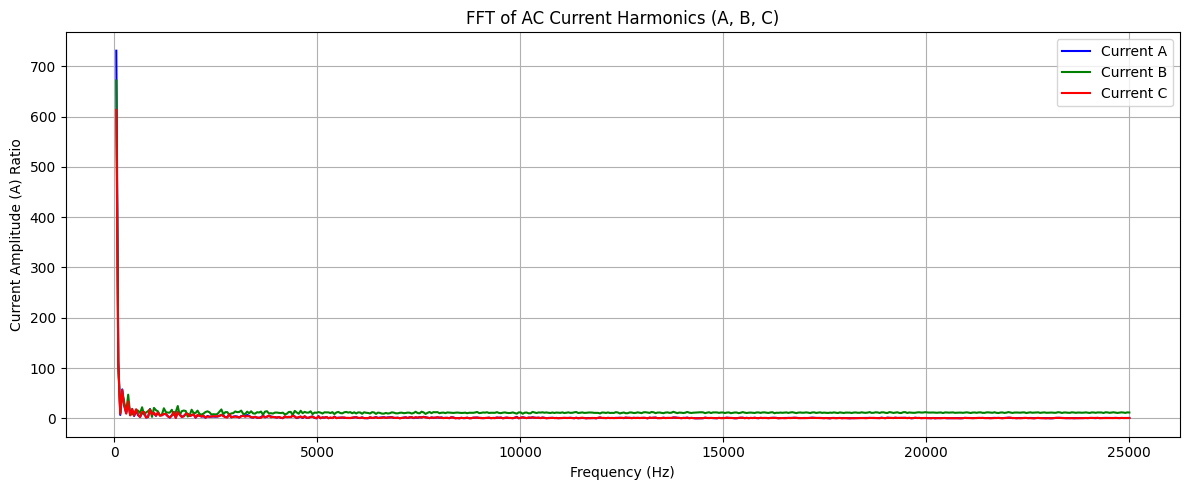

In [12]:
# Set FFT parameters
nfft = 1024  # Number of FFT points
fs = sample_freq  # Sampling frequency

# Compute frequency vector
freq_vector = fft_frequency(nfft, fs, full=False)
print(f"Frequency vector length: {len(freq_vector)}")
print(f"Frequency range: {freq_vector[0]:.2f} Hz to {freq_vector[-1]:.2f} Hz")
print(f"Frequency resolution: {freq_vector[1] - freq_vector[0]:.2f} Hz")

# Display first 10 frequencies
print(f"\nFirst 10 frequencies: {freq_vector[:10]}")

# --- Draw FFT chart for all three phases of current on the same plot ---
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np

# Obtain each phase's current; fallback to array of ones if not available
if 'current_a' in locals():
    signal_a = current_a
else:
    try:
        signal_a = current["Current A Avg"].dropna().values
    except:
        signal_a = np.ones(nfft)

if 'current_b' in locals():
    signal_b = current_b
else:
    try:
        signal_b = current["Current B Avg"].dropna().values
    except:
        signal_b = np.ones(nfft)

if 'current_c' in locals():
    signal_c = current_c
else:
    try:
        signal_c = current["Current C Avg"].dropna().values
    except:
        signal_c = np.ones(nfft)

# Make sure each is long enough for FFT
def pad_signal(sig, length):
    if len(sig) >= length:
        return sig[:length]
    else:
        return np.pad(sig, (0, length - len(sig)), 'constant')

signal_a = pad_signal(signal_a, nfft)
signal_b = pad_signal(signal_b, nfft)
signal_c = pad_signal(signal_c, nfft)

fft_a = fft(signal_a, n=nfft)
fft_b = fft(signal_b, n=nfft)
fft_c = fft(signal_c, n=nfft)

# Calculate amplitude to show the actual value of current (not normalized)
# The FFT output (for real-valued signals) must be scaled as follows:
#   - Right-side bins (except DC and Nyquist) are doubled, to get real amplitude.
#   - Amplitudes are magnitude values, divided by nfft.
def fft_amplitude(fft_result, nfft):
    amp = np.abs(fft_result) / nfft
    # Double all except DC (0) and Nyquist (nfft/2 if even)
    if nfft % 2 == 0:  # even
        amp[1:nfft//2] = amp[1:nfft//2] * 2
    else:  # odd
        amp[1:(nfft+1)//2] = amp[1:(nfft+1)//2] * 2
    return amp[:len(freq_vector)]

fft_amp_a = fft_amplitude(fft_a, nfft)
fft_amp_b = fft_amplitude(fft_b, nfft)
fft_amp_c = fft_amplitude(fft_c, nfft)

plt.figure(figsize=(12, 5))
plt.plot(freq_vector, fft_amp_a, label='Current A', color='b')
plt.plot(freq_vector, fft_amp_b, label='Current B', color='g')
plt.plot(freq_vector, fft_amp_c, label='Current C', color='r')
plt.title('FFT of AC Current Harmonics (A, B, C)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Current Amplitude (A) Ratio')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


### 2. Power Spectral Density (PSD) Analysis

Now let's compute the power spectral density for each phase of voltage and current to analyze their spectral characteristics.


In [13]:
# Compute CPSD between voltage and current for each phase
# Note: cpsd_quasisync_1D can handle signals of different lengths

# Ensure FFT parameters are available (in case this cell is run independently)
if 'nfft' not in locals():
    nfft = 1024  # Number of FFT points
if 'fs' not in locals():
    fs = 50000   # Sampling frequency [Hz]

cpsd_va_ia = cpsd_quasisync_1D(voltage_a, current_a, nfft, fs, window='hann')
cpsd_vb_ib = cpsd_quasisync_1D(voltage_b, current_b, nfft, fs, window='hann')
cpsd_vc_ic = cpsd_quasisync_1D(voltage_c, current_c, nfft, fs, window='hann')

# Also compute CPSD between different phases for comparison
cpsd_va_vb = cpsd_quasisync_1D(voltage_a, voltage_b, nfft, fs, window='hann')
cpsd_ia_ib = cpsd_quasisync_1D(current_a, current_b, nfft, fs, window='hann')

print(f"CPSD array lengths: {len(cpsd_va_ia)}")
print(f"CPSD V-A vs I-A - Max: {np.max(np.abs(cpsd_va_ia)):.2e}, Min: {np.min(np.abs(cpsd_va_ia)):.2e}")
print(f"CPSD V-A vs V-B - Max: {np.max(np.abs(cpsd_va_vb)):.2e}, Min: {np.min(np.abs(cpsd_va_vb)):.2e}")


CPSD array lengths: 512
CPSD V-A vs I-A - Max: 3.30e+00, Min: 9.31e-06
CPSD V-A vs V-B - Max: 4.76e-01, Min: 7.87e-06


In [14]:
# Prepare data for PSD analysis - take a subset for demonstration
# Convert to numpy arrays and remove NaN values
# Use the renamed column names from our organized DataFrame structure
voltage_a = voltage["Phase_A_Voltage"].dropna().values
voltage_b = voltage["Phase_B_Voltage"].dropna().values
voltage_c = voltage["Phase_C_Voltage"].dropna().values
current_a = current["Phase_A_Current"].dropna().values
current_b = current["Phase_B_Current"].dropna().values
current_c = current["Phase_C_Current"].dropna().values

print(f"Data lengths - Voltage A: {len(voltage_a)}, Current A: {len(current_a)}")

# Compute PSD for voltage signals
psd_voltage_a = psd_1D(voltage_a, nfft, fs, window='hann')
psd_voltage_b = psd_1D(voltage_b, nfft, fs, window='hann')
psd_voltage_c = psd_1D(voltage_c, nfft, fs, window='hann')

# Compute PSD for current signals
psd_current_a = psd_1D(current_a, nfft, fs, window='hann')
psd_current_b = psd_1D(current_b, nfft, fs, window='hann')
psd_current_c = psd_1D(current_c, nfft, fs, window='hann')

print(f"PSD array lengths: {len(psd_voltage_a)}")
print(f"PSD voltage A - Max: {np.max(psd_voltage_a):.2e}, Min: {np.min(psd_voltage_a):.2e}")
print(f"PSD current A - Max: {np.max(psd_current_a):.2e}, Min: {np.min(psd_current_a):.2e}")


Data lengths - Voltage A: 2343, Current A: 2343
PSD array lengths: 512
PSD voltage A - Max: 4.74e-01, Min: 7.48e-06
PSD current A - Max: 5.94e+01, Min: 1.60e-04


In [15]:
# CORRECTED CPSD Analysis Cell - Use this instead of any old cells
# This cell uses the correct variable names and will override any old cells

# Compute CPSD between voltage and current for each phase
# Note: cpsd_quasisync_1D can handle signals of different lengths

# Ensure FFT parameters are available (in case this cell is run independently)
if 'nfft' not in locals():
    nfft = 1024  # Number of FFT points
if 'fs' not in locals():
    fs = 50000   # Sampling frequency [Hz]

cpsd_va_ia = cpsd_quasisync_1D(voltage_a, current_a, nfft, fs, window='hann')
cpsd_vb_ib = cpsd_quasisync_1D(voltage_b, current_b, nfft, fs, window='hann')
cpsd_vc_ic = cpsd_quasisync_1D(voltage_c, current_c, nfft, fs, window='hann')

# Also compute CPSD between different phases for comparison
cpsd_va_vb = cpsd_quasisync_1D(voltage_a, voltage_b, nfft, fs, window='hann')
cpsd_ia_ib = cpsd_quasisync_1D(current_a, current_b, nfft, fs, window='hann')

print(f"CPSD array lengths: {len(cpsd_va_ia)}")
print(f"CPSD V-A vs I-A - Max: {np.max(np.abs(cpsd_va_ia)):.2e}, Min: {np.min(np.abs(cpsd_va_ia)):.2e}")
print(f"CPSD V-A vs V-B - Max: {np.max(np.abs(cpsd_va_vb)):.2e}, Min: {np.min(np.abs(cpsd_va_vb)):.2e}")


CPSD array lengths: 512
CPSD V-A vs I-A - Max: 3.30e+00, Min: 9.31e-06
CPSD V-A vs V-B - Max: 4.76e-01, Min: 7.87e-06


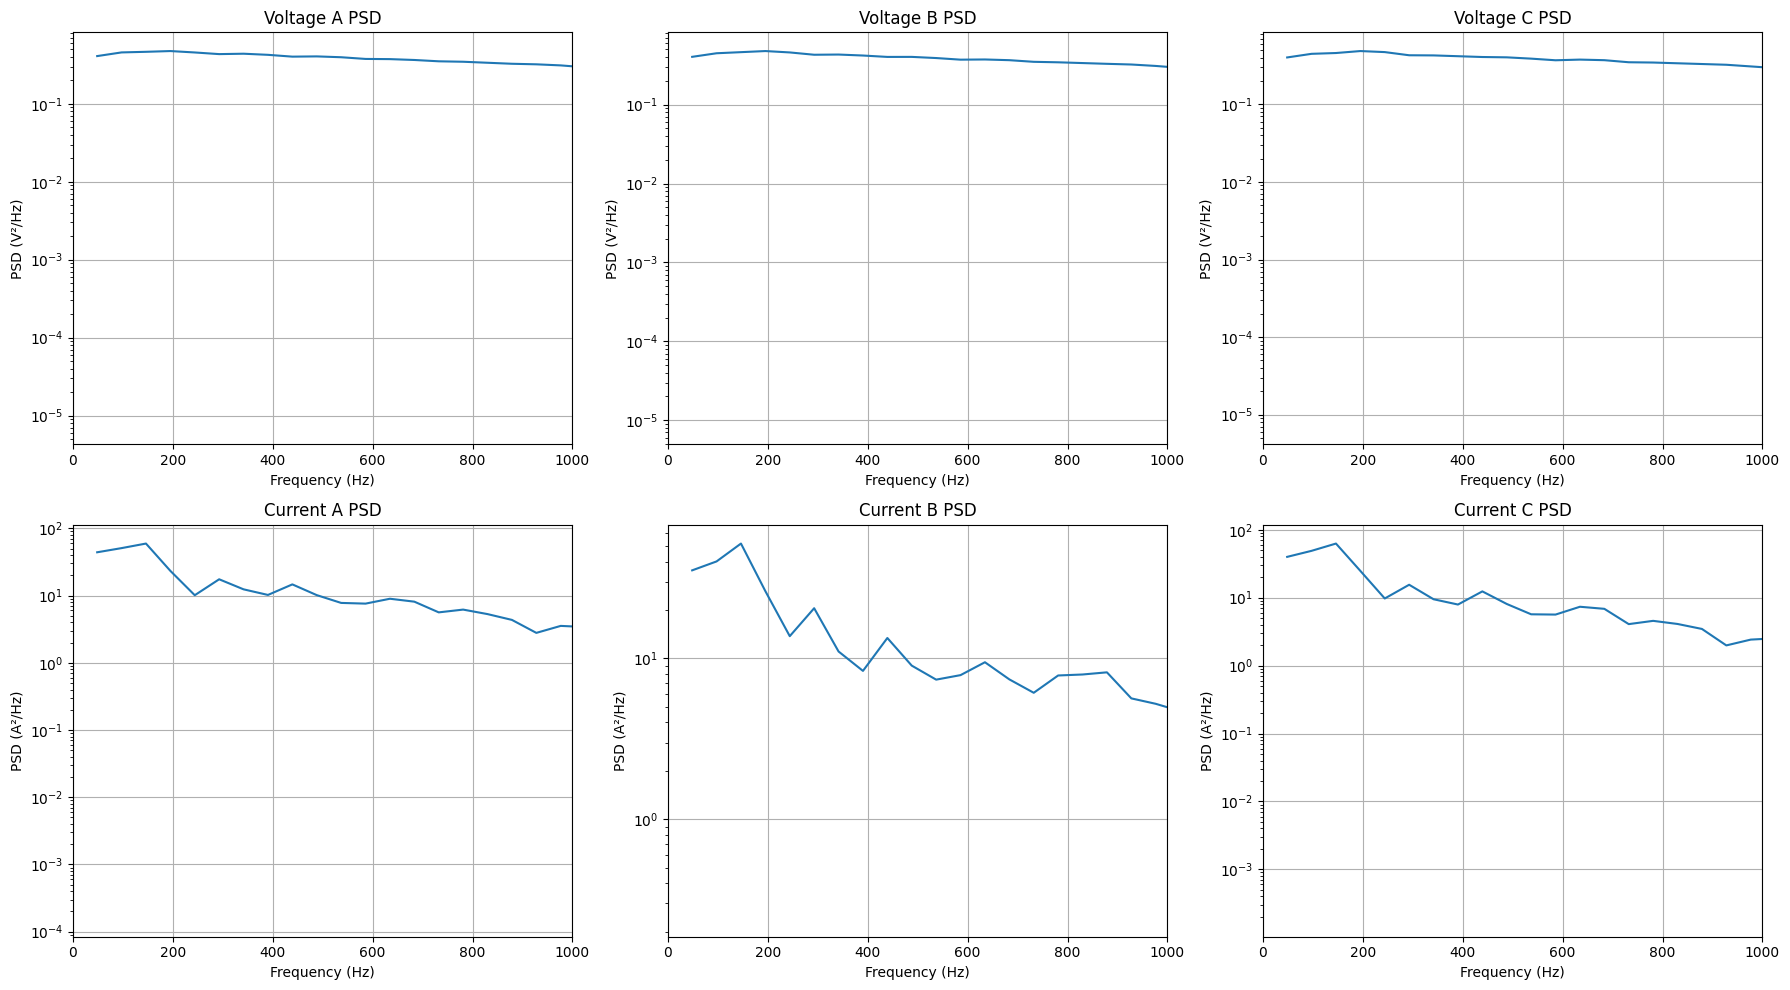

In [16]:
# Plot PSD results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot voltage PSDs
axes[0, 0].semilogy(freq_vector, psd_voltage_a)
axes[0, 0].set_title('Voltage A PSD')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('PSD (V²/Hz)')
axes[0, 0].grid(True)
axes[0, 0].set_xlim(0, 1000)  # Focus on lower frequencies

axes[0, 1].semilogy(freq_vector, psd_voltage_b)
axes[0, 1].set_title('Voltage B PSD')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('PSD (V²/Hz)')
axes[0, 1].grid(True)
axes[0, 1].set_xlim(0, 1000)

axes[0, 2].semilogy(freq_vector, psd_voltage_c)
axes[0, 2].set_title('Voltage C PSD')
axes[0, 2].set_xlabel('Frequency (Hz)')
axes[0, 2].set_ylabel('PSD (V²/Hz)')
axes[0, 2].grid(True)
axes[0, 2].set_xlim(0, 1000)

# Plot current PSDs
axes[1, 0].semilogy(freq_vector, psd_current_a)
axes[1, 0].set_title('Current A PSD')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('PSD (A²/Hz)')
axes[1, 0].grid(True)
axes[1, 0].set_xlim(0, 1000)

axes[1, 1].semilogy(freq_vector, psd_current_b)
axes[1, 1].set_title('Current B PSD')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('PSD (A²/Hz)')
axes[1, 1].grid(True)
axes[1, 1].set_xlim(0, 1000)

axes[1, 2].semilogy(freq_vector, psd_current_c)
axes[1, 2].set_title('Current C PSD')
axes[1, 2].set_xlabel('Frequency (Hz)')
axes[1, 2].set_ylabel('PSD (A²/Hz)')
axes[1, 2].grid(True)
axes[1, 2].set_xlim(0, 1000)

plt.tight_layout()
plt.show()


### 3. Cross Power Spectral Density (CPSD) Analysis

Now let's compute the cross power spectral density between voltage and current signals to analyze their relationship in the frequency domain. This is useful for understanding power quality and phase relationships.


In [17]:
# Compute CPSD between voltage and current for each phase
# Note: cpsd_quasisync_1D can handle signals of different lengths
cpsd_va_ia = cpsd_quasisync_1D(voltage_a, current_a, nfft, fs, window='hann')
cpsd_vb_ib = cpsd_quasisync_1D(voltage_b, current_b, nfft, fs, window='hann')
cpsd_vc_ic = cpsd_quasisync_1D(voltage_c, current_c, nfft, fs, window='hann')

# Also compute CPSD between different phases for comparison
cpsd_va_vb = cpsd_quasisync_1D(voltage_a, voltage_b, nfft, fs, window='hann')
cpsd_ia_ib = cpsd_quasisync_1D(current_a, current_b, nfft, fs, window='hann')

print(f"CPSD array lengths: {len(cpsd_va_ia)}")
print(f"CPSD V-A vs I-A - Max: {np.max(np.abs(cpsd_va_ia)):.2e}, Min: {np.min(np.abs(cpsd_va_ia)):.2e}")
print(f"CPSD V-A vs V-B - Max: {np.max(np.abs(cpsd_va_vb)):.2e}, Min: {np.min(np.abs(cpsd_va_vb)):.2e}")


CPSD array lengths: 512
CPSD V-A vs I-A - Max: 3.30e+00, Min: 9.31e-06
CPSD V-A vs V-B - Max: 4.76e-01, Min: 7.87e-06


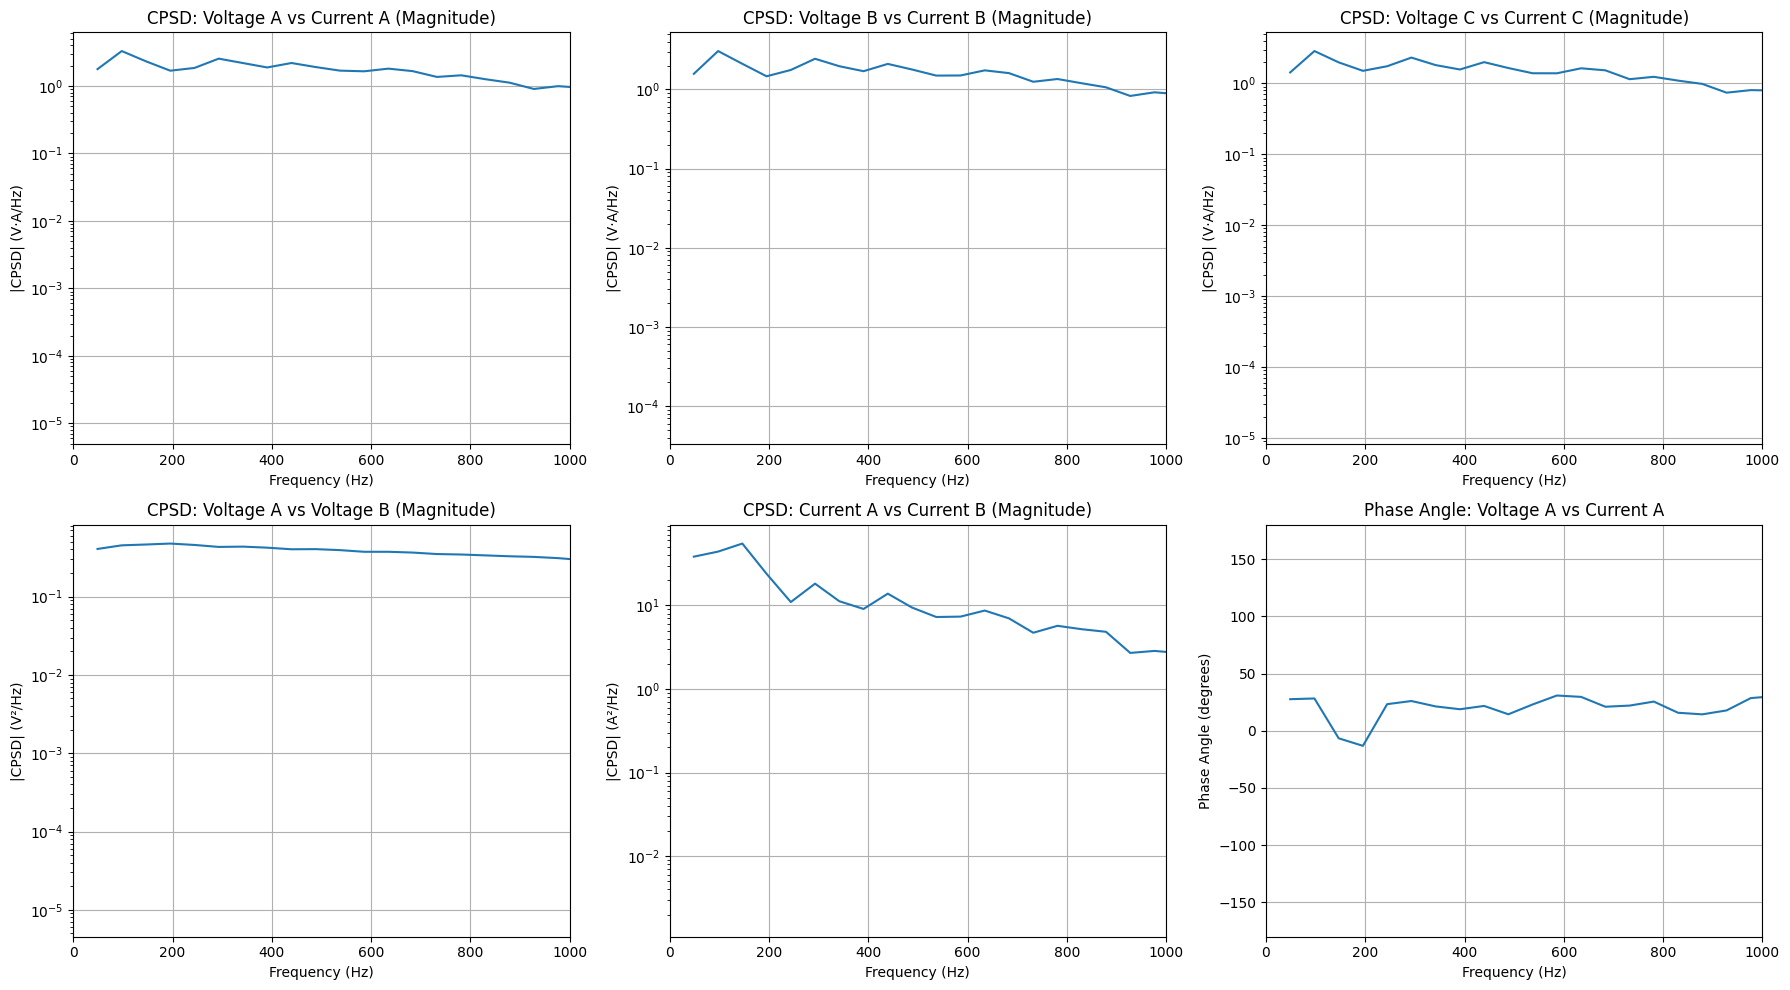

In [18]:
# Plot CPSD results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot voltage-current CPSDs (magnitude)
axes[0, 0].semilogy(freq_vector, np.abs(cpsd_va_ia))
axes[0, 0].set_title('CPSD: Voltage A vs Current A (Magnitude)')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('|CPSD| (V·A/Hz)')
axes[0, 0].grid(True)
axes[0, 0].set_xlim(0, 1000)

axes[0, 1].semilogy(freq_vector, np.abs(cpsd_vb_ib))
axes[0, 1].set_title('CPSD: Voltage B vs Current B (Magnitude)')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('|CPSD| (V·A/Hz)')
axes[0, 1].grid(True)
axes[0, 1].set_xlim(0, 1000)

axes[0, 2].semilogy(freq_vector, np.abs(cpsd_vc_ic))
axes[0, 2].set_title('CPSD: Voltage C vs Current C (Magnitude)')
axes[0, 2].set_xlabel('Frequency (Hz)')
axes[0, 2].set_ylabel('|CPSD| (V·A/Hz)')
axes[0, 2].grid(True)
axes[0, 2].set_xlim(0, 1000)

# Plot phase relationships
axes[1, 0].semilogy(freq_vector, np.abs(cpsd_va_vb))
axes[1, 0].set_title('CPSD: Voltage A vs Voltage B (Magnitude)')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('|CPSD| (V²/Hz)')
axes[1, 0].grid(True)
axes[1, 0].set_xlim(0, 1000)

axes[1, 1].semilogy(freq_vector, np.abs(cpsd_ia_ib))
axes[1, 1].set_title('CPSD: Current A vs Current B (Magnitude)')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('|CPSD| (A²/Hz)')
axes[1, 1].grid(True)
axes[1, 1].set_xlim(0, 1000)

# Plot phase angle for voltage-current relationship
phase_angle = np.angle(cpsd_va_ia)
axes[1, 2].plot(freq_vector, phase_angle * 180 / np.pi)
axes[1, 2].set_title('Phase Angle: Voltage A vs Current A')
axes[1, 2].set_xlabel('Frequency (Hz)')
axes[1, 2].set_ylabel('Phase Angle (degrees)')
axes[1, 2].grid(True)
axes[1, 2].set_xlim(0, 1000)
axes[1, 2].set_ylim(-180, 180)

plt.tight_layout()
plt.show()


### 4. Summary of MHKiT Dolfyn FFT Functions

The three MHKiT dolfyn FFT functions provide comprehensive spectral analysis capabilities:

**`fft_frequency(nfft, fs, full=False)`**
- Computes frequency vector for FFT analysis
- Essential for plotting and interpreting spectral results
- Parameters: number of FFT points, sampling frequency, full spectrum flag

**`psd_1D(a, nfft, fs, window='hann', step=None)`**
- Computes power spectral density of a single signal
- Useful for analyzing individual voltage or current signals
- Provides frequency domain representation of signal power

**`cpsd_quasisync_1D(a, b, nfft, fs, window='hann')`**
- Computes cross power spectral density between two signals
- Handles signals of different lengths (quasi-synchronous)
- Essential for analyzing relationships between voltage and current signals
- Provides both magnitude and phase information

These functions complement the existing MHKiT power module functions and provide advanced spectral analysis capabilities for power quality assessment.


In [19]:
# Finally we can compute the total harmonic current distortion as a percentage
THCD = power.quality.total_harmonic_current_distortion(h_s)
THCD

Phase_A_Current      206.183621
Phase_B_Current      369.463862
Phase_C_Current      207.160852
Harmonic Order     20105.720579
dtype: float64